Initial Data Overview:
   GridId              Toid  GRID_ExactCut_ID Location_ExactCut  \
0    6256  4000000027865913                27          External   
1    6428  4000000027865913                45          External   
2    6600  4000000027865913                74          External   
3    6772  4000000027865913               106          External   
4    6256  4000000027865914                27          External   

  BoroughName_ExactCut  DoT ID  Length (m) Emissions  Year Pollutant  ...  \
0               NonGLA   16001  117.662736       DFT  2013       CO2  ...   
1               NonGLA   16001  504.845737       DFT  2013       CO2  ...   
2               NonGLA   16001  511.909513       DFT  2013       CO2  ...   
3               NonGLA   16001   51.510888       DFT  2013       CO2  ...   
4               NonGLA   16001  114.435065       DFT  2013       CO2  ...   

   Diesel Car  Electric Car  Petrol LGV  Diesel LGV  Electric LGV    TfL Bus  \
0  160.672802           0.0    

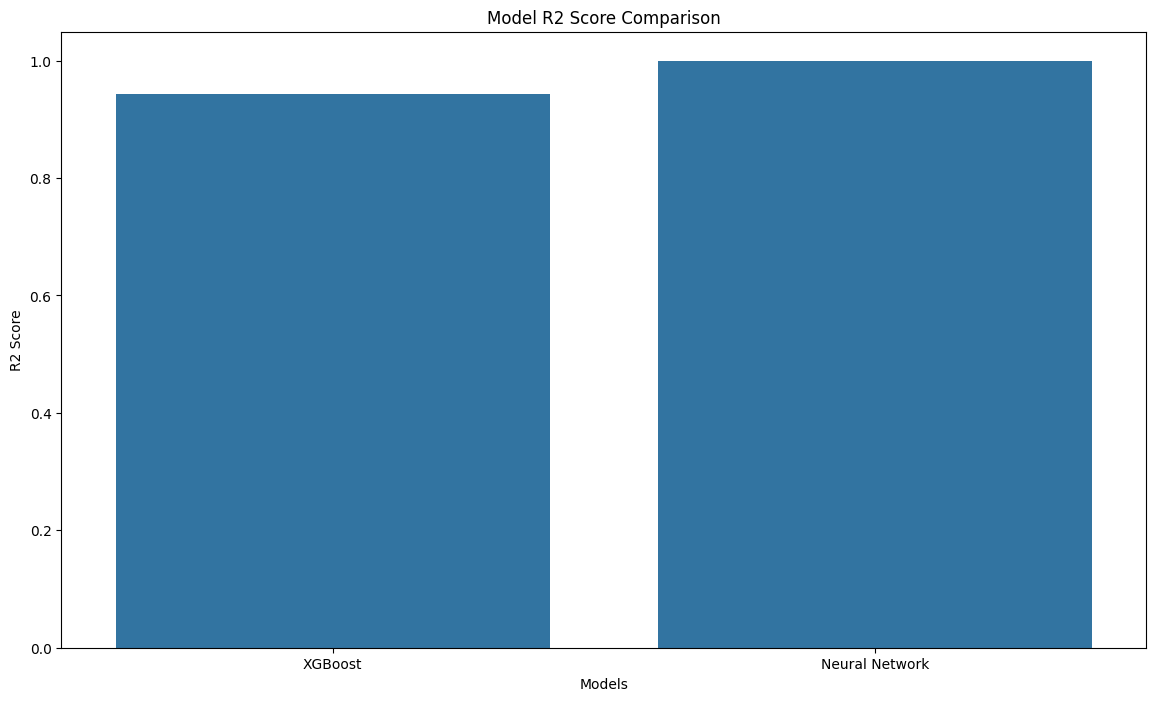

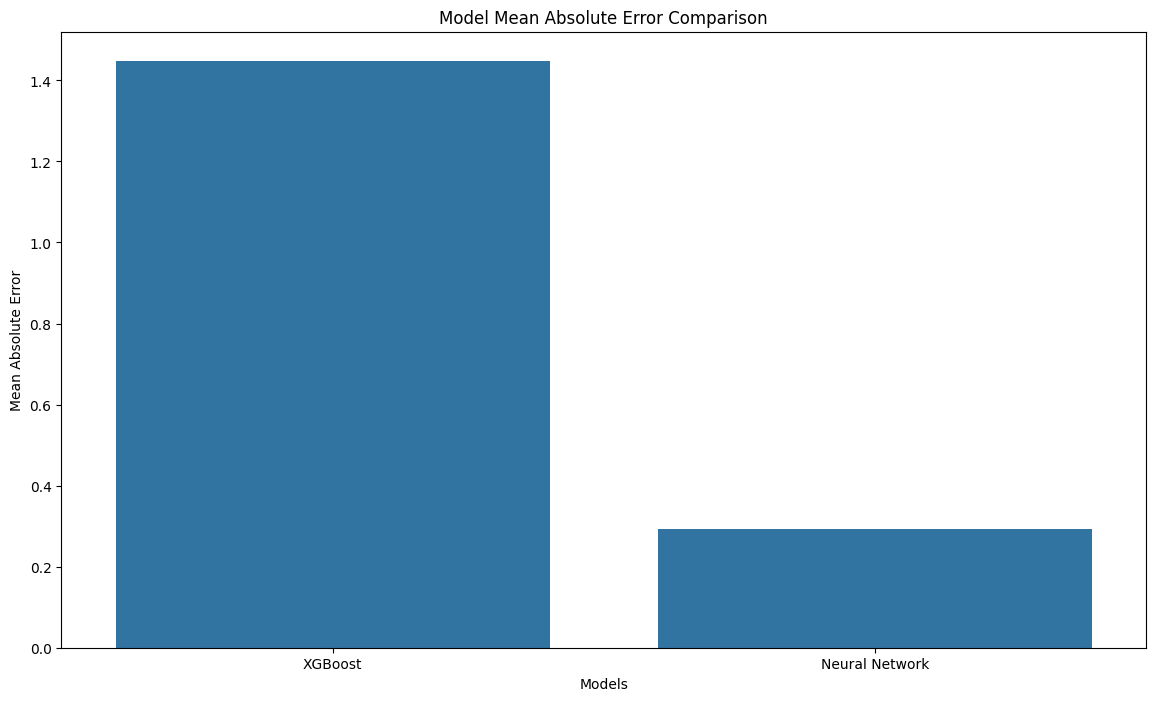

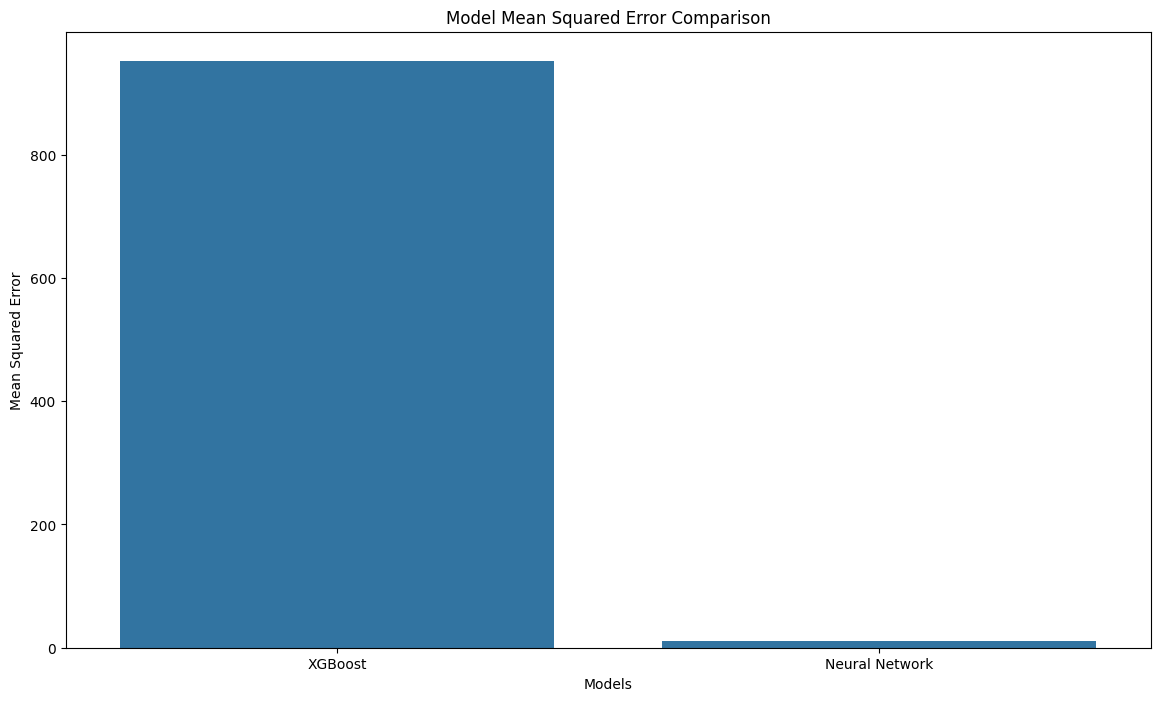

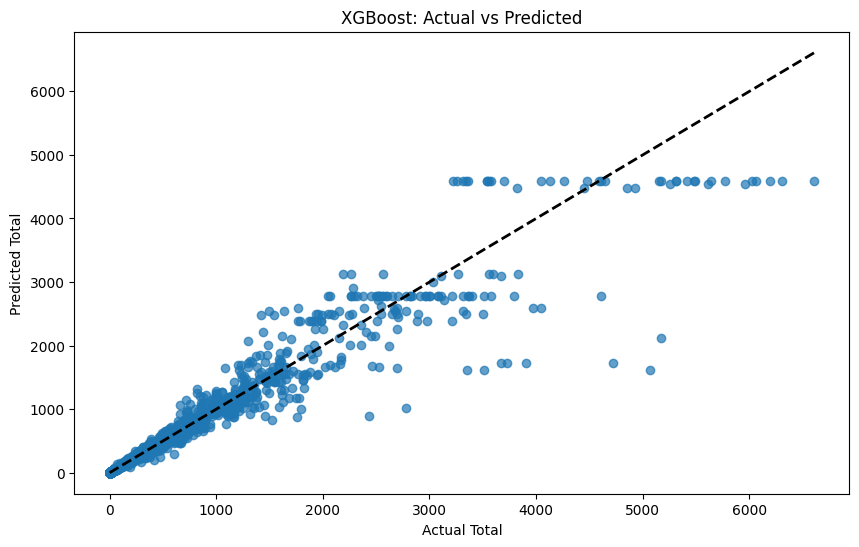

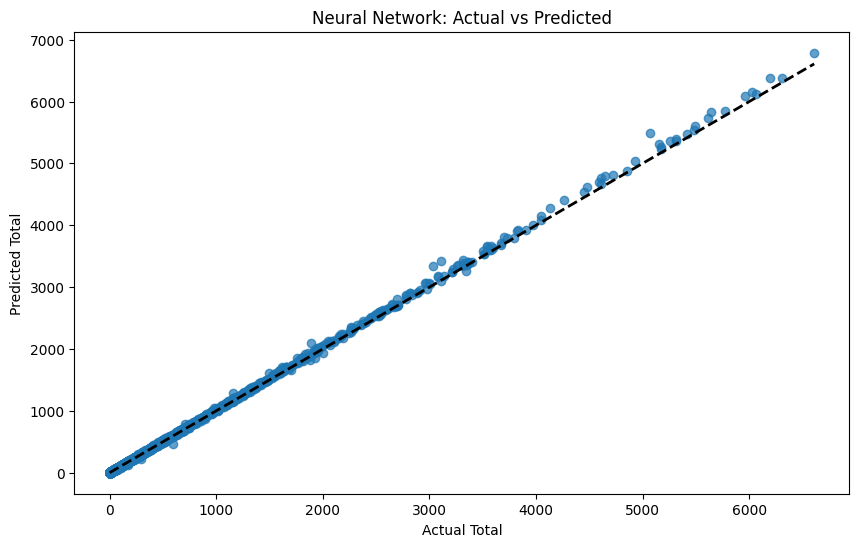


Predictions for XGBoost saved to XGBoost_predictions_with_pollutant_names.csv
        GridId              Toid  GRID_ExactCut_ID Location_ExactCut  \
190891    9190  4000000030455083              1453             Outer   
423604    9003  4000000030217873               759             Outer   
14904    10919  4000000030235494               970             Inner   
89385    10412  4000000030460209              2284             Outer   
105092    8357  4000000030083019              2042             Outer   

       BoroughName_ExactCut  DoT ID  Length (m) Emissions  Year     Pollutant  \
190891                Brent   47096   16.492439    COPERT  2013  PM10_Exhaust   
423604           Hillingdon   74923    4.607958    COPERT  2013   PM25_Resusp   
14904               Lambeth   27610   72.613300       DFT  2013           CO2   
89385             Greenwich  942362   16.231548    COPERT  2013           NOx   
105092             Havering   56211  283.562980    COPERT  2013    PM10_Brake   

 

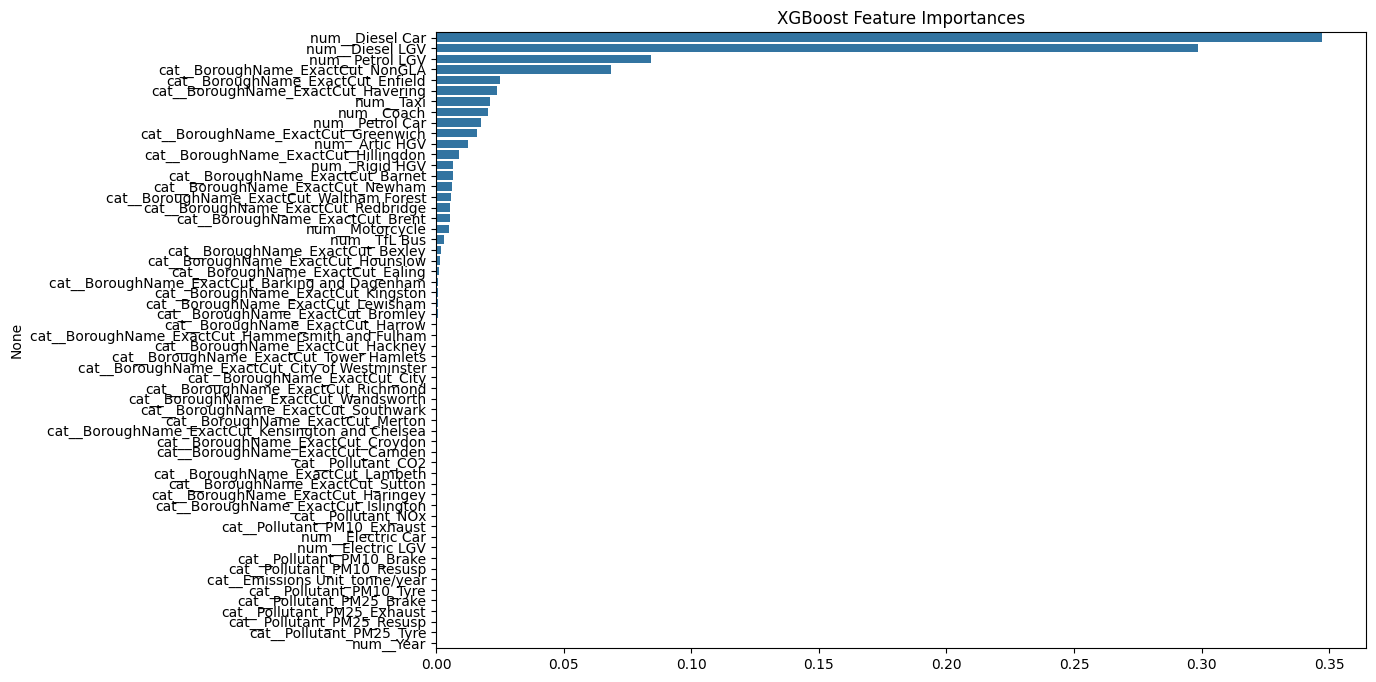


Feature importances for Neural Network saved to Neural Network_feature_importances.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Step 1: Load and Inspect the Data
data = pd.read_excel("/content/drive/MyDrive/dissertation_data/modified_2013_data.xlsx")
print("Initial Data Overview:")
print(data.head())
print(data.info())

# Step 2: Preprocessing
start_time = time.time()

# Handle missing values
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:  # Numerical columns
        data[column].fillna(data[column].mean(), inplace=True)

data['Year'] = data['Year'].astype(int)  # Ensure 'Year' is integer

# Step 3: Define Features and Target
X = data.drop(columns=['Total'])
y = data['Total']  # Target variable

categorical_features = ['Pollutant', 'Emissions Unit', 'BoroughName_ExactCut']
numerical_features = ['Year', 'Motorcycle', 'Taxi', 'Petrol Car', 'Diesel Car',
                      'Electric Car', 'Petrol LGV', 'Diesel LGV', 'Electric LGV',
                      'TfL Bus', 'Coach', 'Rigid HGV', 'Artic HGV']

# Step 4: Column Transformer and Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),          # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define models with improved settings
models = {
    'XGBoost': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators=500, max_depth=8, learning_rate=0.05, subsample=0.8,
                               colsample_bytree=0.8, random_state=42, verbosity=0, n_jobs=-1))
    ]),
    'Neural Network': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42))
    ])
}

# Dictionary to store results for comparison
model_results = {}
predictions_dict = {}
feature_importance_dict = {}

# Step 5: Training, Prediction, and Evaluation
for model_name, pipeline in models.items():
    model_start_time = time.time()
    print(f"\nTraining {model_name}...")

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    predictions = pipeline.predict(X_test)

    # Evaluation Metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Store results
    model_results[model_name] = {
        'Mean Squared Error': mse,
        'Mean Absolute Error': mae,
        'R2 Score': r2
    }

    # Store predictions
    predictions_dict[model_name] = predictions

    # Extract feature importances
    if model_name == 'XGBoost':
        feature_importances = pipeline.named_steps['model'].feature_importances_
        # Combine feature names from numerical and categorical features
        feature_names = preprocessor.get_feature_names_out()
        # Store feature importances
        feature_importance_dict[model_name] = pd.Series(feature_importances, index=feature_names)
    else:
        # Neural Network does not have feature importances
        feature_importance_dict[model_name] = pd.Series([0] * len(preprocessor.get_feature_names_out()), index=preprocessor.get_feature_names_out())

    print(f"{model_name} Evaluation Completed in {time.time() - model_start_time:.2f} seconds.")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")

# Total time for the entire process
print(f"\nTotal Processing Time: {time.time() - start_time:.2f} seconds.")

# Step 6: Visualization of Model Evaluation Results
results_df = pd.DataFrame(model_results).T
print("\nModel Comparison Results:")
print(results_df)

# Plotting R2 Score
plt.figure(figsize=(14, 8))
sns.barplot(x=results_df.index, y='R2 Score', data=results_df)
plt.title('Model R2 Score Comparison')
plt.ylabel('R2 Score')
plt.xlabel('Models')
plt.show()

# Plotting Mean Absolute Error
plt.figure(figsize=(14, 8))
sns.barplot(x=results_df.index, y='Mean Absolute Error', data=results_df)
plt.title('Model Mean Absolute Error Comparison')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Models')
plt.show()

# Plotting Mean Squared Error
plt.figure(figsize=(14, 8))
sns.barplot(x=results_df.index, y='Mean Squared Error', data=results_df)
plt.title('Model Mean Squared Error Comparison')
plt.ylabel('Mean Squared Error')
plt.xlabel('Models')
plt.show()

# Plot Actual vs Predicted for each model
for model_name, predictions in predictions_dict.items():
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.7)
    plt.xlabel('Actual Total')
    plt.ylabel('Predicted Total')
    plt.title(f'{model_name}: Actual vs Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()

# Step 7: Save All Models' Performance Predictions and Feature Importances to CSV
for model_name, predictions in predictions_dict.items():
    results_with_pollutant = X_test.copy()
    results_with_pollutant['Actual_Total'] = y_test
    results_with_pollutant['Predicted_Total'] = predictions

    output_filename = f'{model_name}_predictions_with_pollutant_names.csv'
    results_with_pollutant.to_csv(output_filename, index=False)
    print(f"\nPredictions for {model_name} saved to {output_filename}")
    print(results_with_pollutant.head())

# Save feature importances
for model_name, feature_importances in feature_importance_dict.items():
    feature_importances.sort_values(ascending=False, inplace=True)
    feature_importances.to_csv(f'{model_name}_feature_importances.csv', index=True)
    print(f"\nFeature importances for {model_name} saved to {model_name}_feature_importances.csv")

    if model_name == 'XGBoost':
        # Plot feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x=feature_importances.values, y=feature_importances.index)
        plt.title(f'{model_name} Feature Importances')
        plt.show()
